## Начало лабораторной работы

In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import pandas as pd
from skfuzzy import control as ctrl

df = pd.read_csv('C:/Users/TIGR228/Desktop/МИИ/Lab1/AIM-PIbd-31-Afanasev-S-S/static/csv/diabetes.csv')
#df = df[~df['bedrooms'].between(10, 34)]

df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## Определим входные и выходные переменные

Входные X: Glucose (уровень глюкозы) и BMI (индекс массы тела)

Выходные Y: Outcome (исход по диабету)

In [2]:
glucose = ctrl.Antecedent(np.arange(0, 200, 1), "glucose")
bmi = ctrl.Antecedent(np.arange(0, 70, 1), "bmi")
outcome = ctrl.Consequent(np.arange(0, 2, 1), "outcome")

## Формирование нечетких переменных для лингвистических переменных и их визуализация

c:\Users\TIGR228\Desktop\МИИ\Lab1\AIM-PIbd-31-Afanasev-S-S\aimenv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


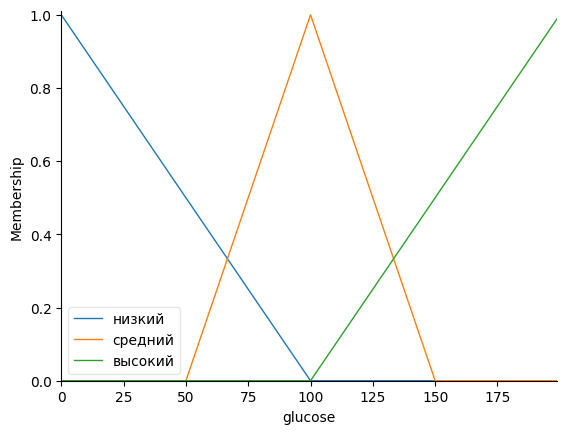

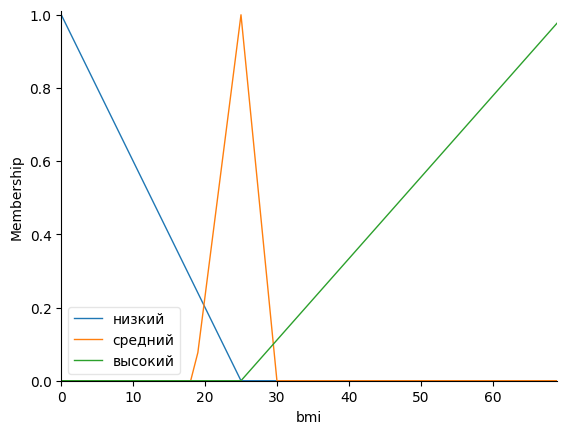

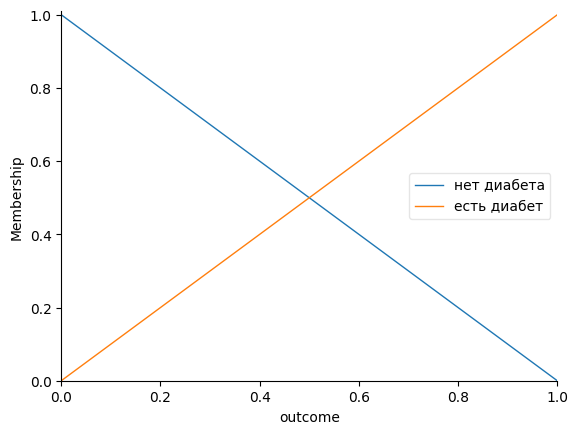

In [3]:

# Определение функций принадлежности для Glucose
glucose['низкий'] = fuzz.trimf(glucose.universe, [0, 0, 100])
glucose['средний'] = fuzz.trimf(glucose.universe, [50, 100, 150])
glucose['высокий'] = fuzz.trimf(glucose.universe, [100, 200, 200])

# Определение функций принадлежности для BMI
bmi['низкий'] = fuzz.trimf(bmi.universe, [0, 0, 25])
bmi['средний'] = fuzz.trimf(bmi.universe, [18.5, 25, 30])
bmi['высокий'] = fuzz.trimf(bmi.universe, [25, 70, 70])

# Определение функций принадлежности для Outcome
outcome['нет диабета'] = fuzz.trimf(outcome.universe, [0, 0, 1])
outcome['есть диабет'] = fuzz.trimf(outcome.universe, [0, 1, 1])

# Визуализация функций принадлежности
glucose.view()
bmi.view()
outcome.view()

## Формирование и визуализация базы нечетких правил

(<Figure size 640x480 with 1 Axes>, <Axes: >)

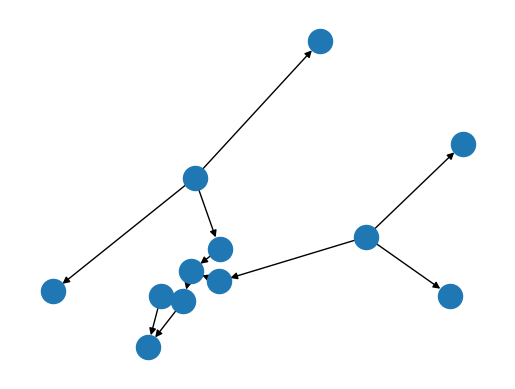

In [4]:

# Определение правил
rule1 = ctrl.Rule(glucose['низкий'] & bmi['низкий'], outcome['нет диабета'])
rule2 = ctrl.Rule(glucose['низкий'] & bmi['средний'], outcome['нет диабета'])
rule3 = ctrl.Rule(glucose['низкий'] & bmi['высокий'], outcome['есть диабет'])
rule4 = ctrl.Rule(glucose['средний'] & bmi['низкий'], outcome['нет диабета'])
rule5 = ctrl.Rule(glucose['средний'] & bmi['средний'], outcome['есть диабет'])
rule6 = ctrl.Rule(glucose['средний'] & bmi['высокий'], outcome['есть диабет'])
rule7 = ctrl.Rule(glucose['высокий'] & bmi['низкий'], outcome['есть диабет'])
rule8 = ctrl.Rule(glucose['высокий'] & bmi['средний'], outcome['есть диабет'])
rule9 = ctrl.Rule(glucose['высокий'] & bmi['высокий'], outcome['есть диабет'])

rule1.view()

## Создание нечеткой системы и добавление нечетких правил в базу знаний нечеткой системы

In [5]:
outcome_ctrl = ctrl.ControlSystem(
    [
        rule1,
        rule2,
        rule3,
        rule4,
        rule5,
        rule6,
        rule7,
        rule8,
        rule9,
    ]
)

outcomes = ctrl.ControlSystemSimulation(outcome_ctrl)

## Пример расчета выходной переменной outcome на основе входных переменных glucose и bmi

In [8]:
outcomes.input["glucose"] = 116
outcomes.input["bmi"] = 33
outcomes.compute()
outcomes.print_state()
outcomes.output["outcome"]

 Antecedents 
Antecedent: glucose                 = 116
  - низкий                          : 0.0
  - средний                         : 0.68
  - высокий                         : 0.16
Antecedent: bmi                     = 33
  - низкий                          : 0.0
  - средний                         : 0.0
  - высокий                         : 0.17777777777777778

 Rules 
RULE #0:
  IF glucose[низкий] AND bmi[низкий] THEN outcome[нет диабета]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - glucose[низкий]                                        : 0.0
  - bmi[низкий]                                            : 0.0
                           glucose[низкий] AND bmi[низкий] = 0.0
  Activation (THEN-clause):
                                      outcome[нет диабета] : 0.0

RULE #1:
  IF glucose[низкий] AND bmi[средний] THEN outcome[нет диабета]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  

np.float64(0.5429990966576332)

## Тестирование нечеткой системы

In [11]:
# Функция для предсказания
def fuzzy_pred(row):
    outcomes.input['glucose'] = row['Glucose']
    outcomes.input['bmi'] = row['BMI']
    outcomes.compute()
    return outcomes.output['outcome']

res = df[['Glucose', 'BMI', 'Outcome']].head(100)

res['Pred'] = res.apply(fuzzy_pred, axis=1)

res.head(15)

Glucose   BMI  Outcome      Pred
0       148  33.6        1  0.546095
1        85  26.6        0  0.598549
2       183  23.3        1  0.648593
3        89  28.1        0  0.558266
4       137  43.1        1  0.585501
5       116  25.6        0  0.640808
6        78  31.0        1  0.532540
7       115  35.3        0  0.554757
8       197  30.5        1  0.529893
9       125   0.0        1  0.452381
10      110  37.6        0  0.566202
11      168  38.0        1  0.568158
12      139  27.1        0  0.589627
13      189  30.1        1  0.527766
14      166  25.8        1  0.637910

## Оценка результатов на основе метрик для задачи регрессии

In [12]:
import math
from sklearn import metrics

# Вычисление метрик
rmetrics = {}
rmetrics["RMSE"] = math.sqrt(metrics.mean_squared_error(res['Outcome'], res['Pred']))
rmetrics["RMAE"] = metrics.mean_absolute_error(res['Outcome'], res['Pred'])
rmetrics["R2"] = metrics.r2_score(res['Outcome'], res['Pred'])

rmetrics

{'RMSE': 0.5172348603024656,
 'RMAE': np.float64(0.5107233852036642),
 'R2': -0.14771300176795843}